In [2]:
import  matplotlib
%matplotlib inline
import matplotlib.pyplot as plt;
import seaborn as sns; sns.set()

import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Categorical, Beta

import torch
import numpy as np
import pandas as pd
import math
import random

In [2]:
class Card:
    def __init__(self, face):
        """
        Value: {1, ..., 10, 11, 12, 13} - 11 is J, 12 is Q, 13 is K
        """
        self.face = face
        self.value = faces_to_values[face]
    
    def __repr__(self):
        return self.face

In [975]:
class Deck():
    def __init__(self, num_suites, to_remove=None):
        self.value_dict = {i:0 for i in range(12)}
        self.num_suites = num_suites
        
        for _ in range(num_suites):
            for value in [2,3,4,5,6,7,8,9,10,10,10,10,11]:
#                 new_card = Card(face)
                self.value_dict[value] += 1
    
        if to_remove is not None:
            for value in to_remove:
                self.value_dict[value] -= 1



    def get_value_probs(self):
        total_sum = sum(list(self.value_dict.values()))
        probs = np.zeros(12)
        for key,val in self.value_dict.items():
            probs[key] = val
        return probs / float(total_sum)
    
    def __rep__(self):
        return self.value_dict
    
    def draw_and_observe_card(self, obs_name):
        likelihood = Categorical(self.get_value_probs())
        new_card = int(pyprob.observe(likelihood, name=obs_name))
        self.value_dict[new_card] -= 1
        return new_card
    
    def draw_card(self):
        value = int(pyprob.sample(Categorical(self.get_value_probs())))
        self.value_dict[value] -= 1
        return value
    
    def copy(self):
        temp = Deck(self.num_suites)
        temp.value_dict = self.value_dict.copy()
        return temp


class Blackjack(Model):
    
    def __init__(self, num_suites):
        super().__init__(name='Number game')
        self.num_suites = num_suites
        self.cards = {}

    
    def _deal(self, deck):
        
        # Dealer
        dealer_card1 = deck.draw_card()
        dealer_card2 = deck.draw_card()
        self.cards['dealer'] = [dealer_card1, dealer_card2]
        
        # Player
        player_card1 = deck.draw_and_observe_card('pcard_1')
        player_card2 = deck.draw_and_observe_card('pcard_2')
        self.cards['player'] = [player_card1, player_card2]
        
    def forward_game(self):
        """
        Generative sampling process
        """                
        
        deck = Deck(self.num_suites)

        dealer_card1 = deck.draw_card()
        dealer_card2 = deck.draw_card()
        self.cards['dealer'] = [dealer_card1, dealer_card2]
        
        
        player_card1 = deck.draw_card()
        player_card2 = deck.draw_card()
        self.cards['player'] = [player_card1, player_card2]
        
        score = sum(self.cards['dealer'])
#         print('dealer initial cards ', self.cards['dealer'])
        
        
        for i in range(1,7):
            if score < 16:
                new_card = deck.draw_card()
                self.cards['dealer'] = self.cards['dealer'] + [new_card]
                score += new_card
            else:
                probs = np.zeros(12)
                probs[0] = 1
                deterministic = Categorical(probs)
                pyprob.observe(deterministic, value=0, name='obs{}'.format(i))
        
#         
        return deck, self.cards['player'], self.cards['dealer'], score
            
    
    def forward(self):
        """
        Generative sampling process
        """                
        
        deck = Deck(self.num_suites)
        self._deal(deck)
        
        score = sum(self.cards['dealer'])
        
        for i in range(1,7):
            if score < 16:
                likelihood = Categorical(deck.get_value_probs())
                new_card = deck.draw_and_observe_card('obs{}'.format(i))
                self.cards['dealer'] = self.cards['dealer'] + [new_card]
                score += new_card
            else:
                probs = np.zeros(12)
                probs[0] = 1
                deterministic = Categorical(probs)
                pyprob.observe(deterministic, value=0, name='obs{}'.format(i))
        
#         print(self.cards['dealer'])
#         print(self.cards['player'])
#         print(deck.value_dict)
        return score
    
    
model = Blackjack(num_suites=4)
model_nn = Blackjack(num_suites=4)

# Prior on Dealer Score

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:00:22 | 0d:00:00:00 | #################### | 10000/10000 | 441.49       


/Users/theo/anaconda3/envs/csis/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


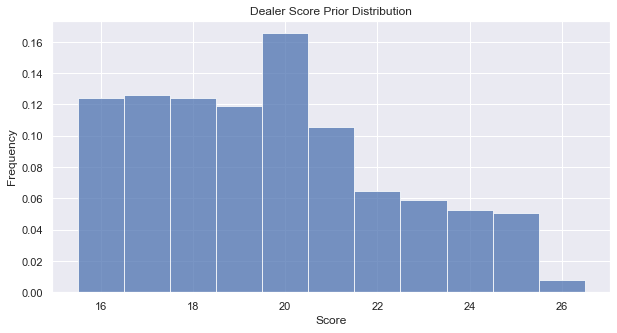

In [855]:
prior = model.prior_results(num_traces=10000)

combined = prior.combine_duplicates()
hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
sorted_p = sorted(hypothesis, key=lambda x: x[0], reverse=False)
bins=np.array([val[0] for val in sorted_p] + [sorted_p[-1][0]+1]) - 0.5

prior.plot_histogram(show=False, alpha=0.75, label='empirical prior', bins=bins)
plt.title('Dealer Score Prior Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Dealer Score Posterior - Importance Sampling

### Few Samples

### Many Samples

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:00:23 | 0d:00:00:00 | #################### | 10000/10000 | 430.78       


(24, 0.9999853750933164)


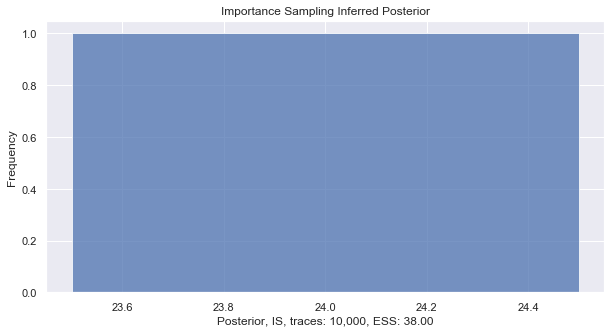

In [399]:
obs = {'pcard_1':5, 'pcard_2':5, 'obs1':5, 'obs2':4, 'obs3':2, 'obs4':9, 'obs5':0, 'obs6':0}

posterior_many = model.posterior_results(
                    num_traces=10000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe=obs) # assign values to the observed values

combined = posterior_many.combine_duplicates()
hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
sorted_p = sorted(hypothesis, key=lambda x: x[0], reverse=False)
 
print('\n')

sorted_p = sorted(hypothesis, key=lambda x: x[1], reverse=True)

posterior_many.plot_histogram(show=False, alpha=0.75, bins=np.array([val[0] for val in sorted_p] + [sorted_p[-1][0]+1]) - 0.5, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')

sorted_p = sorted(hypothesis, key=lambda x: x[1], reverse=True)
for el in sorted_p:
    print(el)

# Inference Compilation

In [1032]:
# model.reset_inference_network()
model.learn_inference_network(num_traces=1000000,
                              observe_embeddings={
                                                  'pcard_1': {'dim' : 32},
                                                  'pcard_2': {'dim' : 32},
                                                  'obs1': {'dim' : 32},
                                                  'obs2': {'dim' : 32},
                                                  'obs3': {'dim' : 32},
                                                  'obs4': {'dim' : 32},
                                                  'obs5': {'dim' : 32},
                                                  'obs6': {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Continuing to train existing inference network...
Total number of parameters: 2,291,620
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
0d:02:05:42 | 1    | 2,099,904 | +4.94e+00 | +2.86e+00 | +3.54e+00 | 0d:00:57:07 | +1.00e-03 | 310.5 
Stop condition reached. num_traces: 1000000
0d:02:05:42 | 1    | 2,100,032 | +4.94e+00 | +2.86e+00 | +3.45e+00 | 0d:00:57:08 | +1.00e-03 | 312.0 


## Inference NN Importance Sampling

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:00:43 | 0d:00:00:00 | #################### | 10000/10000 | 227.50       


(24, 0.1904025722668545)
(23, 0.18939450222361773)
(25, 0.1509738329367655)
(22, 0.13677493397064705)
(21, 0.08792883482467405)
(20, 0.07096721926618545)
(19, 0.06414626746742176)
(18, 0.047604493147837074)
(17, 0.04042131413431767)
(16, 0.021386029761679123)


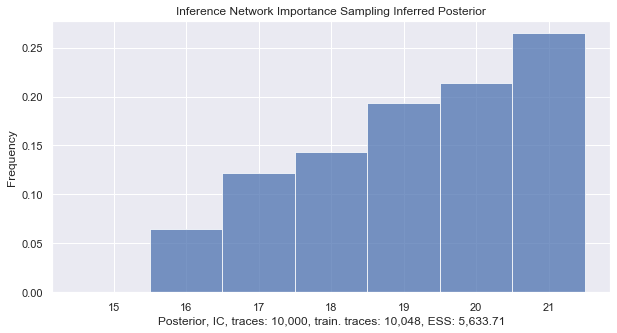

In [618]:
obs = {'pcard_1':2, 'pcard_2':2, 'obs1':10, 'obs2':0, 'obs3':0, 'obs4':0, 'obs5':0, 'obs6':0}

posterior_nn = model.posterior_results(num_traces=10000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                    observe=obs) # assign values to the observed values

combined = posterior_nn.combine_duplicates()
hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.001]
sorted_p = sorted(hypothesis, key=lambda x: x[0], reverse=False)
 
print('\n')

posterior_nn.plot_histogram(show=False, alpha=0.75, bins=np.arange(15,23) - 0.5, label='inferred posterior')
plt.title('Inference Network Importance Sampling Inferred Posterior')

sorted_p = sorted(hypothesis, key=lambda x: x[1], reverse=True)
for el in sorted_p:
    print(el)

## Inference Normal Importance Sampling

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 311.50       


[15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5]
(22, 0.22613041345052246)
(24, 0.19723633312470124)
(23, 0.16080406991380478)
(25, 0.1293968895692654)
(19, 0.08040199646509566)
(21, 0.07035173439771235)
(16, 0.04020105566400911)
(18, 0.04020105566400911)
(17, 0.04020105566400911)
(20, 0.015075396086869888)


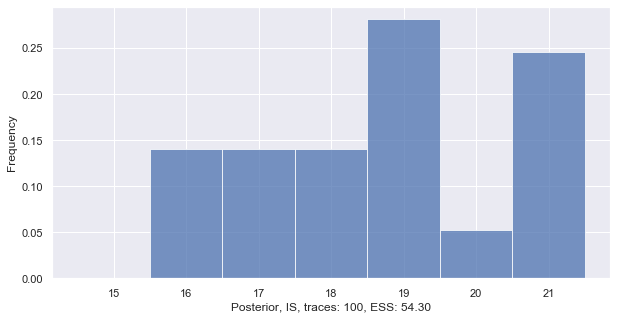

In [535]:
posterior_few = model.posterior_results(
                    num_traces=100, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe=obs) # assign values to the observed values

combined = posterior_few.combine_duplicates()
hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
sorted_p = sorted(hypothesis, key=lambda x: x[0], reverse=False)

print('\n')
print(np.array([val[0] for val in sorted_p] + [sorted_p[-1][0]+1]) - 0.5)

posterior_few.plot_histogram(show=False, alpha=0.75, bins=np.arange(15,23) - 0.5, label='inferred posterior')
# posterior_few.plot_histogram(show=False, alpha=0.75, bins=np.array([val[0] for val in sorted_p] + [sorted_p[-1][0]+1]) - 0.5, label='inferred posterior')
# plt.title('Importance Sampling Inferred Posterior')

sorted_p = sorted(hypothesis, key=lambda x: x[1], reverse=True)
for el in sorted_p:
    print(el)

# Simulating Games

## My strategy

In [911]:
def calc_EV(x, deck, dealerDistribution):
    
    EV_table = {}
    
    def calc_EV_helper(x, deck, dealerDistribution):
        
        if x in EV_table:
            return EV_table[x]
                
        if x > 21:
            EV_table[x] = ((1 - dealerDistribution.p_bust) * (-1), False)
            return EV_table[x]
        
        elif x <= 21:
            
            EV_stay_dealer_bust = dealerDistribution.p_bust * (1)
            EV_stay_dealer_no_bust = (1 - dealerDistribution.p_bust) * (dealerDistribution.p_less_than(x) * (1) + dealerDistribution.p_greater_than(x) * (-1))
            EV_stay = EV_stay_dealer_bust + EV_stay_dealer_no_bust
            
            EV_hit = 0
            
            value_probs = deck.get_value_probs()
            
            for i in range(value_probs.shape[0]):
                val,prob = i, value_probs[i]
                if prob > 0:
                    deck_copy = deck.copy()
                    deck_copy.value_dict[val] -= 1
                    EV_hit += prob * calc_EV_helper(x + val, deck_copy, dealerDistribution)[0]

        if EV_hit > EV_stay:
            EV_table[x] = (EV_hit, True)
        else:
            EV_table[x] = (EV_stay, False)
        return EV_table[x]
    
    return calc_EV_helper(x, deck, dealerDistribution)

# calc_EV(obs['pcard_1'] + obs['pcard_2'], deck, DealerDistribution(posterior_few))
            
prior_EV = []
for i in range(3,25):
    
    EV, play = calc_EV(i, Deck(4), DealerDistribution(prior))
    prior_EV.append((i, EV,play))
prior_EV

[(3, -0.1306665553682983, True),
 (4, -0.15437846764942978, True),
 (5, -0.17069429406342262, True),
 (6, -0.14643506850868207, True),
 (7, -0.0915416844166299, True),
 (8, -0.027229817336628992, True),
 (9, 0.045100391911046145, True),
 (10, 0.14020785350969178, True),
 (11, 0.14735713958909363, True),
 (12, -0.23745906743696893, True),
 (13, -0.2727300340493445, True),
 (14, -0.30469780913043304, True),
 (15, -0.3439239857366131, True),
 (16, -0.2550601991852728, False),
 (17, -0.06365688871930633, False),
 (18, 0.12774642174666007, False),
 (19, 0.3140239079674423, False),
 (20, 0.5316668720951284, False),
 (21, 0.7392118328590135, False),
 (22, -0.7650004950656135, False),
 (23, -0.7650004950656135, False),
 (24, -0.7650004950656135, False)]

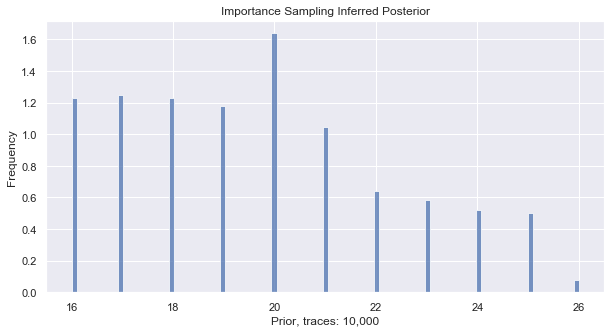

In [912]:
DealerDistribution(prior).plot()

## Infer Dealer Distribution

In [143]:
class DealerDistribution:
    
    def __init__(self, posterior):
        self.posterior = posterior
        self.probs = {}
        self.p_bust = 0
        combined = posterior.combine_duplicates()
        posterior_probs = {combined[i]:np.exp(combined._get_log_weight(i).item()) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001}
        for key, prob in posterior_probs.items():
            if key <= 21:
                self.probs[key] = prob
            else:
                self.p_bust += prob

    def p_less_than(self, x):
        p = 0
        for key,prob in self.probs.items():
            if key < x:
                p += prob
        return p
    
    def p_greater_than(self, x):
        p = 0
        for key,prob in self.probs.items():
            if key > x:
                p += prob
        return p
    
    def plot(self):
        self.posterior.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
        plt.title('Importance Sampling Inferred Posterior')
        return


In [1013]:
def infer_dealer_score(model, player_cards, dealer_cards, num_traces, use_nn=False):

    observations = {}
    observations['pcard_1'], observations['pcard_2'] = player_cards[0], player_cards[1]

    for i in range(2,8):
        if i < len(dealer_cards):
            observations['obs{}'.format(i-1)] = dealer_cards[i]
        else:
            observations['obs{}'.format(i-1)] = 0

    print(observations)
    if use_nn:
        posterior = model.posterior_results(num_traces=num_traces, # the number of samples estimating the posterior
                            inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                            observe=observations) # assign values to the observed values
    else:
        posterior = model.posterior_results(
                            num_traces=num_traces, # the number of samples estimating the posterior
                            inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                            observe=observations) 
        
    dealer_posterior = DealerDistribution(posterior)
    return dealer_posterior

In [967]:

player_cards = [3,9]
dealer_cards = [10,6,2]

# deck, player_cards, dealer_cards, score = model.forward_game()
print(dealer_cards)
print(player_cards)

dealerDistribution = infer_dealer_score(model, player_cards, dealer_cards, 500, use_nn=False)

[10, 6, 2]
[3, 9]
[10, 6, 2]
[10, 6, 2]
[10, 6, 2]
[10, 6, 2]
[10, 6, 2]
[10, 6, 2]
{'pcard_1': 3, 'pcard_2': 9, 'obs1': 2, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 500/500 | 457.26       


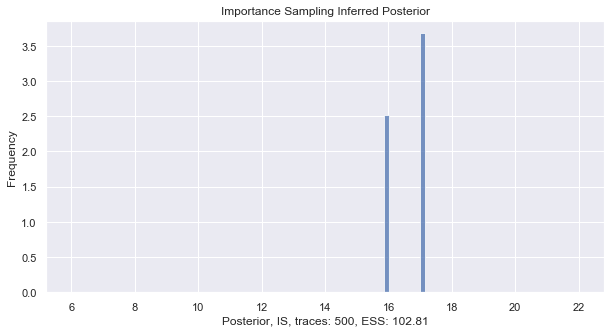

In [953]:
dealerDistribution.plot()

In [944]:
player_cards = [3,9]
dealer_cards = [10,6,11]

observations = {}
observations['pcard_1'], observations['pcard_2'] = player_cards[0], player_cards[1]

for i in range(2,8):
    if i < len(dealer_cards):
        observations['obs{}'.format(i-1)] = dealer_cards[i]
    else:
        observations['obs{}'.format(i-1)] = 0
        
to_remove = player_cards + dealer_cards
            
deck = Deck(4, to_remove)
print(deck.value_dict)


{0: 0, 1: 0, 2: 4, 3: 3, 4: 4, 5: 4, 6: 3, 7: 4, 8: 4, 9: 3, 10: 15, 11: 3}


In [983]:
calc_EV(16, deck, DealerDistribution(prior))

(-0.2550601991852728, False)

## Simulate n Games

In [1048]:
def play(player_cards, dealer_cards, dealer_dist):
    to_remove = player_cards + dealer_cards
    deck = Deck(4, to_remove)
    print(deck.value_dict)
    
    score = sum(player_cards)
    EV, should_hit = calc_EV(score, deck, dealer_dist)
    print("EV: {}, HIT: {}, Score: {}".format(EV, should_hit, score))
    
    while should_hit:
        new_card = deck.draw_card()
        print('new player card: {}'.format(new_card))
        score += new_card
        EV, should_hit = calc_EV(score, deck, dealer_dist)
        print("EV: {}, HIT: {}, Score: {}".format(EV, should_hit, score))
        
    print(EV, score)
    return score

def payout(player_score, dealer_score):
    if player_score > 21:
        if dealer_score > 21:
            return 0
        else:
            return -1
    else:
        if dealer_score > 21 or (player_score > dealer_score):
            return 1
        elif player_score < dealer_score:
            return -1
        elif player_score == dealer_score:
            return 0
    raise Error('Should not get here')

def simulate_day(n, model, dealer_dist_prior):

    total_wealth_prior = []
    total_wealth_nn_is = []
    total_wealth_is = []


    for i in range(n):
        deck, player_cards, dealer_cards, score = model.forward_game()

        # Just the prior
        print('\n')
        print('Player Cards: {}'.format(player_cards))
        print('Dealer Cards: {}'.format(dealer_cards))
        inferred_dealer_dist = dealer_dist_prior
        player_score = play(player_cards, dealer_cards, inferred_dealer_dist)
        dealer_score = sum(dealer_cards)
        total_wealth_prior.append(payout(player_score, dealer_score))
        
        # NN IS
        print('\n')
        print('Player Cards: {}'.format(player_cards))
        print('Dealer Cards: {}'.format(dealer_cards))
        inferred_dealer_dist = infer_dealer_score(model, player_cards, dealer_cards, 100, True)
        player_score = play(player_cards, dealer_cards, inferred_dealer_dist)
        dealer_score = sum(dealer_cards)
        total_wealth_nn_is.append(payout(player_score, dealer_score))
        
        # IS
        print('\n')
        print('Player Cards: {}'.format(player_cards))
        print('Dealer Cards: {}'.format(dealer_cards))
        inferred_dealer_dist = infer_dealer_score(model, player_cards, dealer_cards, 100, False)
        player_score = play(player_cards, dealer_cards, inferred_dealer_dist)
        dealer_score = sum(dealer_cards)
        total_wealth_is.append(payout(player_score, dealer_score))
            
    return total_wealth_prior, total_wealth_nn_is, total_wealth_is

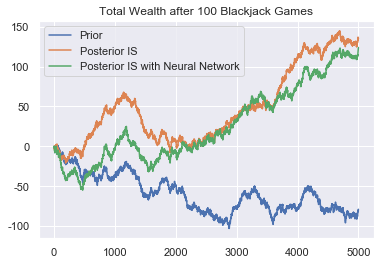

In [1045]:
plot_wealth(total_wealth_prior_200_t_5k, total_wealth_nn_is_200_t_5k, total_wealth_is_200_t_5k)

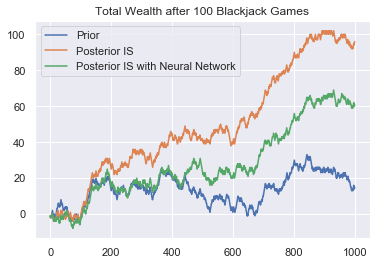

In [1036]:
plot_wealth(total_wealth_prior, total_wealth_nn_is, total_wealth_is)

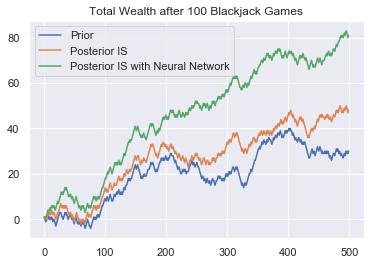

In [1043]:
plot_wealth(total_wealth_prior_200_t, total_wealth_nn_is_200_t, total_wealth_is_200_t)

In [1047]:
for wealth in [total_wealth_prior_200_t_5k, total_wealth_nn_is_200_t_5k, total_wealth_is_200_t_5k]:
    print(np.sum(wealth))

-79
124
136


In [ ]:
total_wealth_prior_100_t_5k, total_wealth_nn_is_100_t_5k, total_wealth_is_100_t_5k = simulate_day(10000, model, dealer_dist_prior)



Player Cards: [2, 3]
Dealer Cards: [6, 9, 9]
{0: 0, 1: 0, 2: 3, 3: 3, 4: 4, 5: 4, 6: 3, 7: 4, 8: 4, 9: 2, 10: 16, 11: 4}
EV: -0.17840719278733505, HIT: True, Score: 5
new player card: 10
EV: -0.35022625251624717, HIT: False, Score: 15
-0.35022625251624717 15


Player Cards: [2, 3]
Dealer Cards: [6, 9, 9]
{'pcard_1': 2, 'pcard_2': 3, 'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 100/100 | 192.93       
{0: 0, 1: 0, 2: 3, 3: 3, 4: 4, 5: 4, 6: 3, 7: 4, 8: 4, 9: 2, 10: 16, 11: 4}
EV: 0.42696162951323663, HIT: True, Score: 5
new player card: 2
EV: 0.4340168921525517, HIT: True, Score: 7
new player card: 10
EV: 0.42508898361268, HIT: False, Score: 17
0.42508898361268 17


Player Cards: [2, 3]
Dealer Cards: [6, 9, 9]
{'pcard_1': 2, 'pcard_2': 3, 'obs1': 9, 'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress    

In [1041]:
np.sum(total_wealth_prior_500_t), np.sum(total_wealth_nn_is_500_t), np.sum(total_wealth_is_500_t)

(30, 81, 48)

In [1027]:

def plot_wealth(total_wealth_prior, total_wealth_nn_is, total_wealth_is):
    plt.title('Total Wealth after 100 Blackjack Games')
    plt.plot(pd.Series(total_wealth_prior).cumsum().values, label='Prior')
    plt.plot(pd.Series(total_wealth_is).cumsum().values, label='Posterior IS')
    plt.plot(pd.Series(total_wealth_nn_is).cumsum().values, label='Posterior IS with Neural Network')
    plt.legend()


# EV Plot

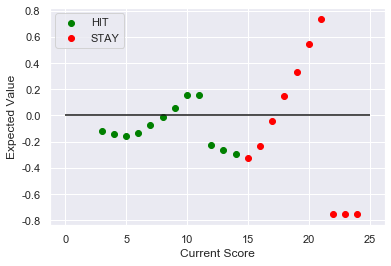

In [377]:
prior_EV = np.array(prior_EV)
hit_EV = prior_EV[prior_EV[:,2] == 1]
stay_EV = prior_EV[prior_EV[:,2] == 0]


plt.scatter(hit_EV[:,0], hit_EV[:,1], c='green', label='HIT')
plt.scatter(stay_EV[:,0], stay_EV[:,1], c='red', label='STAY')
# plt.title('Expected Value at ')
plt.xlabel('Current Score')
plt.ylabel('Expected Value')
plt.hlines(0,0,25)
plt.legend()
plt.savefig('EV_plot.png')

## Plot Divergences

In [ ]:
def get_emp_prob(posterior):
    combined = posterior.combine_duplicates()
    hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
    print(hypothesis)
    probs = np.zeros(30)
    for value,prob in hypothesis:
        probs[value] = prob
    
    return list(probs)

In [566]:
def plot_divergences(obs, true_post, trace_count):
    divergences_total = []
    divergences_nn_total = []
        
    for num_traces in trace_count:
        divergences = []
        divergences_nn = []
        for i in range(10):
            posterior = model.posterior_results(
                        num_traces=num_traces, # the number of samples estimating the posterior
                        inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                        observe=obs)
            posterior_nn = model.posterior_results(
                        num_traces=num_traces, # the number of samples estimating the posterior
                        inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                        observe=obs)

            emp_probs = get_emp_prob(posterior)
            emp_probs_nn = get_emp_prob(posterior_nn)
            divergence = calc_divergence(Categorical(true_post), Categorical(emp_probs))
            divergence_nn = calc_divergence(Categorical(true_post), Categorical(emp_probs_nn))
            divergences.append(divergence)
            divergences_nn.append(divergence_nn)
        divergences_total.append(np.mean(divergences))
        divergences_nn_total.append(np.mean(divergence_nn))
        
    return divergences_total, divergences_nn_total

def plot(divergences_total, divergences_nn_total, trace_count):

    plt.plot(trace_count, divergences_total, label='importance sampling')
    plt.plot(trace_count, divergences_nn_total, label='inference compilation')
    plt.yscale('log')
    plt.title('Number of traces vs. divergence')
    plt.ylabel('Divergence')
    plt.xlabel('Number of traces')
    plt.legend()
    plt.savefig('traces_vs_divergence_both_{}_averaged.png'.format(max_traces))

In [546]:
def calc_divergence(p, q):
    t = np.exp(p.logits) - np.exp(q.logits)
    t[(q.probs == 0).expand_as(t)] = 0
    t[(p.probs == 0).expand_as(t)] = 0
    return abs(t.sum(-1).numpy())

In [556]:
calc_divergence(Categorical(get_emp_prob(few_posterior)), Categorical(get_emp_prob(posterior_nn)))

NameError: name 'few_posterior' is not defined

In [570]:
obs = {'pcard_1':2, 'pcard_2':2, 'obs1':10, 'obs2':0, 'obs3':0, 'obs4':0, 'obs5':0, 'obs6':0}
max_traces = 500
trace_count = range(50, max_traces+50, 50)
divergences_total, divergences_nn_total = plot_divergences(obs, get_emp_prob(posterior_nn), trace_count)

[(16, 0.021522177781917683), (25, 0.16738808599922403), (17, 0.03911762163996257), (22, 0.13474984808181537), (20, 0.07237444861151827), (21, 0.09043255361656358), (23, 0.1784668415972909), (19, 0.06384091603776042), (18, 0.04843048426662955), (24, 0.18367702236731726)]
Time spent  | Time remain.| Progress             | Trace | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 50/50 | 551.10       
Time spent  | Time remain.| Progress             | Trace | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 50/50 | 224.07       
[(17, 0.04097310503563782), (20, 0.08194624930236216), (19, 0.08194624930236216), (22, 0.22151087086223875), (23, 0.07682457533676851), (24, 0.15877077097160652), (18, 0.04097310503563782), (25, 0.23559535688555314), (21, 0.061459658655393566)]
[(22, 0.16140171570552703), (18, 0.011932791925577458), (20, 0.08790230952149414), (23, 0.25543184545145214), (21, 0.07782942655426096), (24, 0.08260016715750207), (16, 0.006210608542851099), (17, 0

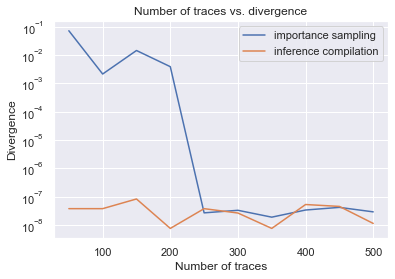

In [571]:
plot(divergences_total, divergences_nn_total, trace_count)

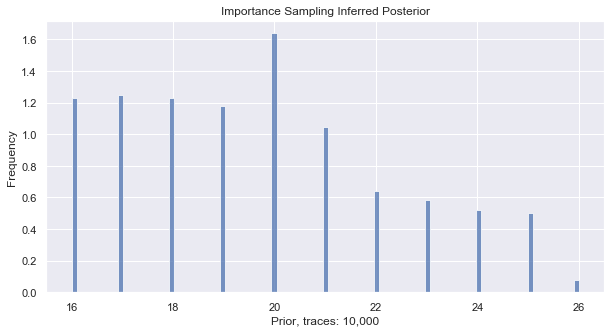

In [979]:
DealerDistribution(prior).plot()